In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from srf.plotting import plot_simulation

<Figure size 1200x600 with 0 Axes>

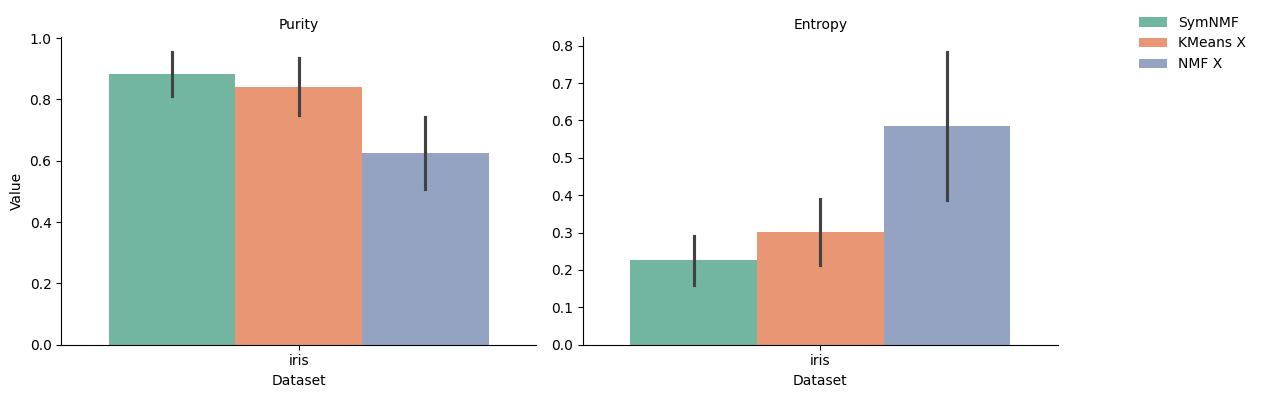

In [18]:
# remove dataset haxby-faces if it exists
# df = df[df["Dataset"] != "haxby-faces"]
# df = df[df["Dataset"] != "diabetes"]

df_clustering = pd.read_csv("../results/benchmarks/clustering_benchmarks.csv")

df_clustering = df_clustering.drop(columns=["Accuracy"])
df_clustering["Model"] = df_clustering["Model"].replace("SyNMF ADMM", "SymNMF")


# Melt the dataframe to have a long-form dataframe suitable for facetgrid
df_melted = df_clustering.melt(
    id_vars=["Dataset", "Model", "Seed"],
    # value_vars=["Purity", "Entropy", "Sparseness"],
    value_vars=["Purity", "Entropy"],
    var_name="Metric",
    value_name="Value",
)


df_clustering.groupby(["Dataset", "Model"]).agg(
    {"Purity": ["mean", "std", "max", "min"]}
)

# Create a FacetGrid for the different metrics
plt.figure(figsize=(12, 6))
g = sns.FacetGrid(
    df_melted,
    col="Metric",
    sharey=False,
    height=4,
    aspect=1.2,
    col_wrap=2,
    sharex=False,
)
g.map_dataframe(
    sns.barplot, x="Dataset", y="Value", hue="Model", errorbar="sd", palette="Set2"
)

# Adjust the legend and labels
g.add_legend(bbox_to_anchor=(1.05, 1), loc="upper left")
g.set_axis_labels("Dataset", "Value")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

# Clustering to see how well this model actually works!

In [56]:
# Clean imports (remove duplicates)
from srf.simulation import generate_simulation_data, SimulationParams
from srf.helpers import compute_metrics, map_labels_with_hungarian
from sklearn.decomposition import NMF
from srf.mixed.admm import ADMM
from tools.rsa import compute_similarity
import numpy as np
import pandas as pd
import itertools
from joblib import Parallel, delayed

# Configuration
SIMULATION_PARAMS = SimulationParams(
    n=150,
    k=10,
    p=150,
    snr=1.0,
    primary_concentration=1.0,
    base_concentration=0.1,
)

METRICS = ["ARI", "NMI", "Accuracy", "Entropy"]


def make_non_negative(data):
    """Shift data to be non-negative if needed."""
    return data - data.min() if data.min() < 0 else data


def create_models(k, seed, nmf_max_iter):
    """Create model configurations for clustering experiments."""
    return {
        "NMF X": {
            "model": NMF(
                n_components=k,
                init="random",
                solver="mu",
                random_state=seed,
                max_iter=nmf_max_iter,
                tol=0.0,
            ),
            "needs_similarity": False,
        },
        "SymNMF": {
            "model": ADMM(
                rank=k,
                max_outer=10,
                w_inner=100,
                tol=0.0,
                verbose=False,
                rho=1.0,
            ),
            "needs_similarity": True,
        },
    }


def prepare_data(X):
    """Prepare data for clustering models."""
    X_shifted = make_non_negative(X)
    S = compute_similarity(X, X, "linear")
    S = S - S.min()
    S = S / S.max()
    return X_shifted, S


def get_model_labels(model, data):
    """Extract cluster labels from a fitted model."""
    W = model.fit_transform(data)
    return np.argmax(W, axis=1)


def evaluate_single_experiment(noise_level, seed, nmf_max_iter):
    """Run clustering experiment for a single noise level and seed."""
    # Generate data
    SIMULATION_PARAMS.snr = noise_level
    SIMULATION_PARAMS.rng_state = seed
    X, M, _, _ = generate_simulation_data(SIMULATION_PARAMS)
    true_labels = np.argmax(M, axis=1)

    # Prepare data
    X_shifted, S = prepare_data(X)

    # Create models
    models = create_models(SIMULATION_PARAMS.k, seed, nmf_max_iter)

    # Evaluate each model
    results = []
    for model_name, model_config in models.items():
        # Select appropriate data
        data = S if model_config["needs_similarity"] else X_shifted
        data = make_non_negative(data)

        # Get predictions
        predicted_labels = get_model_labels(model_config["model"], data)
        matches = map_labels_with_hungarian(true_labels, predicted_labels)

        # Compute metrics
        ari, nmi, purity, entropy = compute_metrics(true_labels, matches)
        metric_values = [ari, nmi, purity, entropy]

        # Store results
        for metric, value in zip(METRICS, metric_values):
            results.append(
                {
                    "SNR": noise_level,
                    "Seed": seed,
                    "Model": model_name,
                    "Metric": metric,
                    "Value": value,
                }
            )

    return results


def run_clustering_experiments(
    seeds=range(10), nmf_max_iter=1000, noise_levels=np.linspace(0.0, 1.0, 10)
):

    print(
        f"Running experiments with {len(seeds)} seeds and {len(noise_levels)} noise levels..."
    )

    # Run experiments in parallel
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_single_experiment)(noise, seed, nmf_max_iter)
        for noise, seed in itertools.product(noise_levels, seeds)
    )

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]

    return pd.DataFrame(flattened_results)


# Run the experiments
df = run_clustering_experiments(
    nmf_max_iter=300, seeds=range(30), noise_levels=np.linspace(0.0, 1.0, 10)
)

Running experiments with 30 seeds and 10 noise levels...


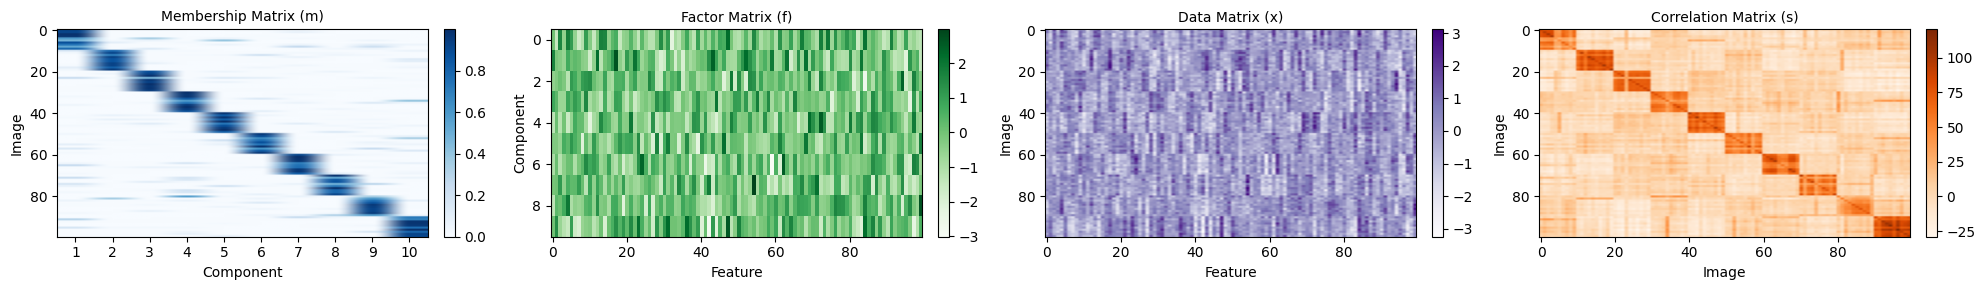

In [ ]:
from srf.simulation import generate_simulation_data, SimulationParams

SIMULATION_PARAMS = SimulationParams(
    n=100,
    k=10,
    p=100,
    snr=0.8,
    primary_concentration=5.0,
    base_concentration=0.1,
)

X, M, F, S = generate_simulation_data(SIMULATION_PARAMS)

fig = plot_simulation(X, M, F, S)

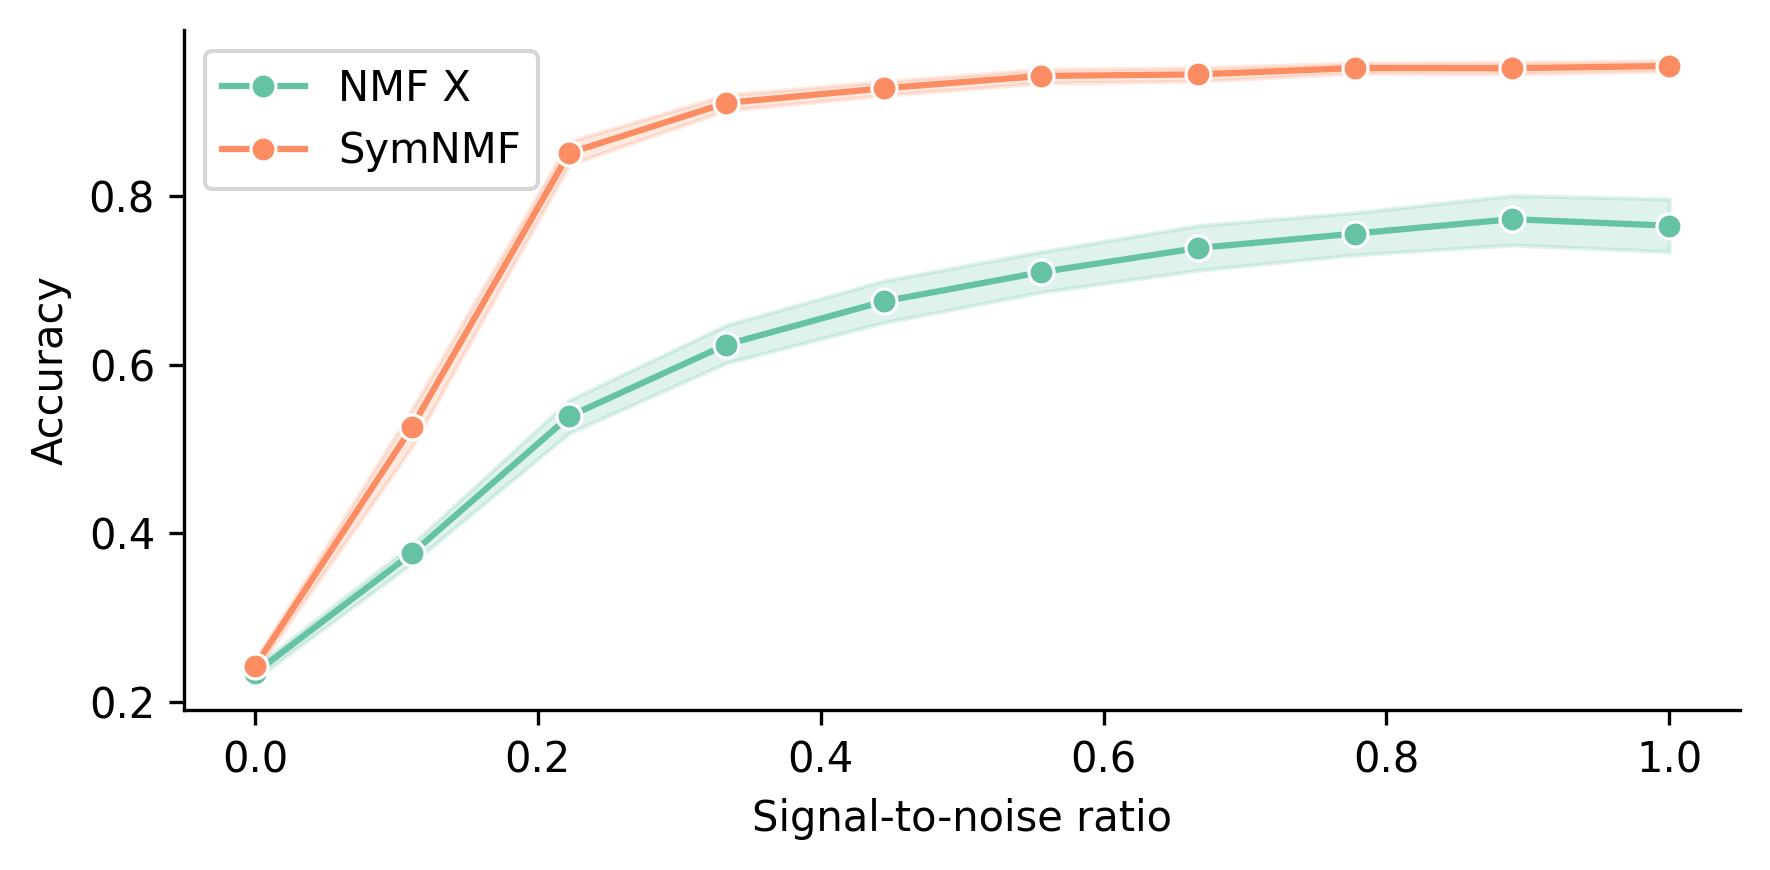

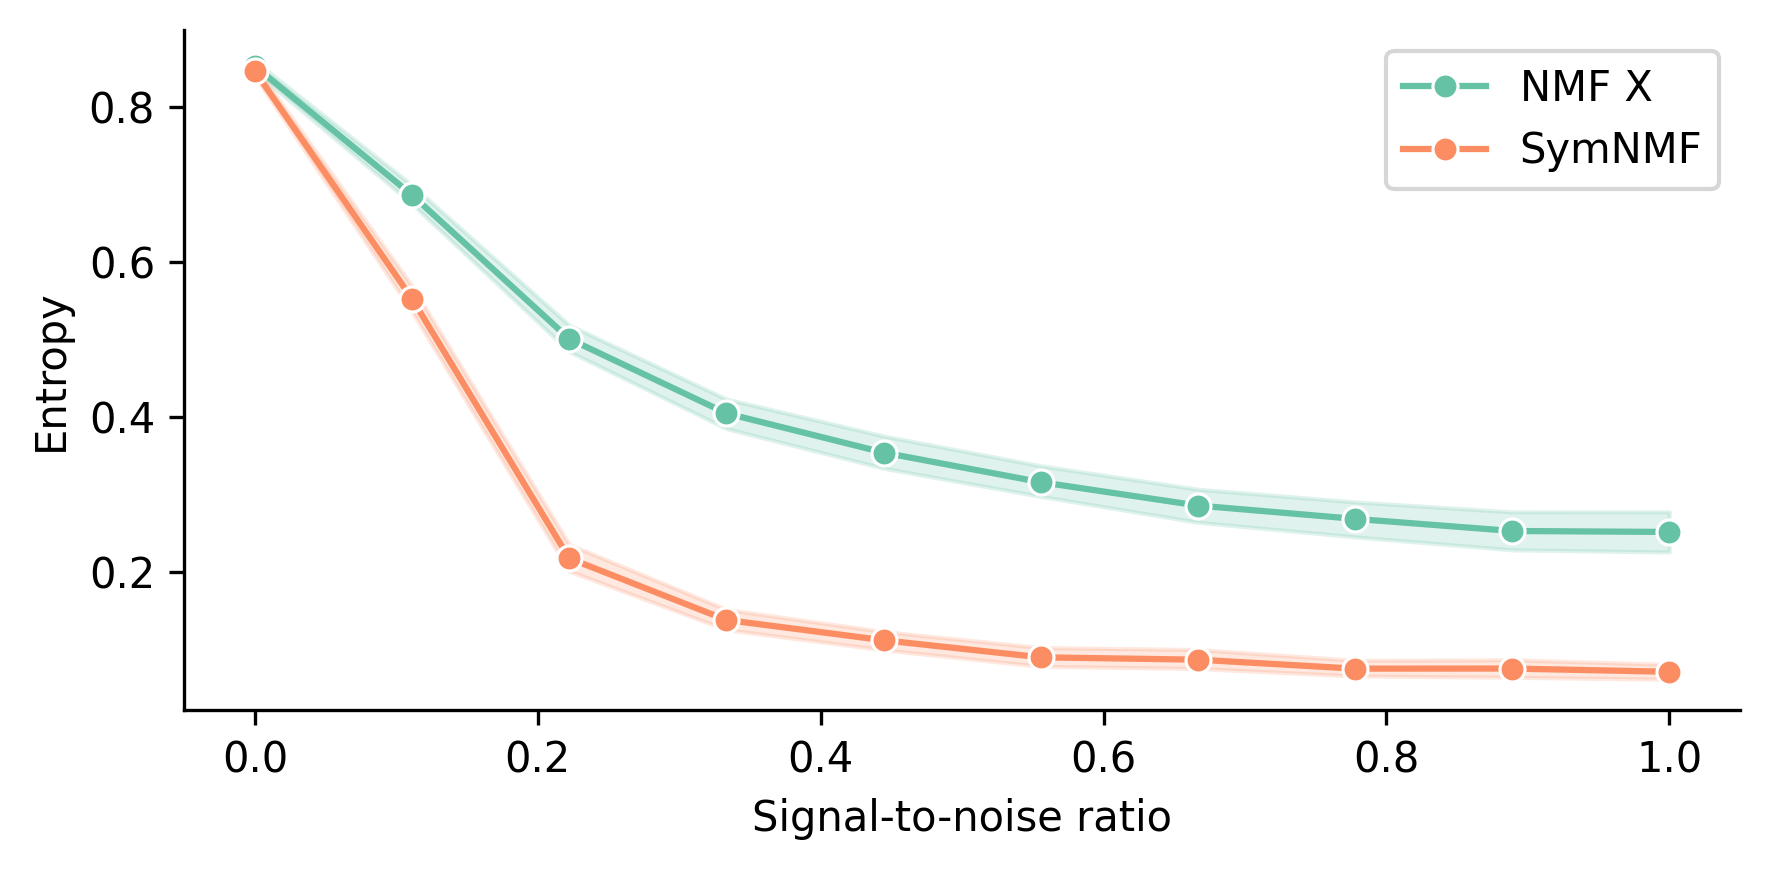

In [58]:
# Make a seaborn lineplot of the metric called ARI
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
df_Accuracy = df[df["Metric"] == "Accuracy"]
sns.lineplot(
    data=df_Accuracy, x="SNR", y="Value", hue="Model", marker="o", palette="Set2", ax=ax
)
sns.despine()
ax.set_ylabel("Accuracy")
ax.set_xlabel("Signal-to-noise ratio")
ax.legend(title="")
fig.tight_layout()

fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
df_entropy = df[df["Metric"] == "Entropy"]
sns.lineplot(
    data=df_entropy, x="SNR", y="Value", hue="Model", marker="o", palette="Set2", ax=ax
)
sns.despine()
ax.set_ylabel("Entropy")
ax.set_xlabel("Signal-to-noise ratio")

# make the legend without a title
ax.legend(title="")
fig.tight_layout()

plt.show()

In [ ]:
# df_without_nmf = df[df["Model"] != "NMF X"]
# Make a plot the shows the differences better. a lineplot, the lines are very close to each other, so i need something else
pivot_df = df.pivot_table(
    index=["Model", "SNR"],
    columns="Metric",
    values="Value",  # Assuming this is your value column
    aggfunc="mean",
)

# Plot heatmap for each metric side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for ax, metric in zip(axes, ["Purity", "Entropy"]):
    # Extract data for this metric and reshape
    heat_data = pivot_df[metric].unstack(level=0)

    # Create heatmap
    sns.heatmap(heat_data, annot=True, cmap="viridis", fmt=".3f", ax=ax)
    ax.set_title(f"{metric} by Model and SNR")

    # Format y-axis labels to two decimal places
    ax.set_yticklabels(
        [f"{float(label.get_text()):.3f}" for label in ax.get_yticklabels()]
    )

plt.tight_layout()
plt.show()

g = sns.catplot(
    data=df,
    x="Model",
    y="Value",  # Assuming this is your value column
    col="Metric",
    kind="box",
    height=4,
    aspect=0.8,
    col_wrap=2,
    palette="Set2",
    hue="Model",
)

# Improve readability
g.set_xticklabels(rotation=45, ha="right")

# Add legend
g.add_legend(title="Model")

plt.show()